# **ML Lab**

This notebook is developed for educational purposes only.
- Authors: Amber Wang, Erin Yu & Ajit Panesar (IDEA Lab, Imperial College London)
- Version: v1 (20/01/2026)
- Comments and corrections to a.panesar@imperial.ac.uk, a.wang20@imperial.ac.uk

--------------

# **(f) Property predictor and its usage in Inverse generator training**

### **Table of Contents**

1\) Create the Property Predictor

2\) Build and train the inverse generator considering property consistency

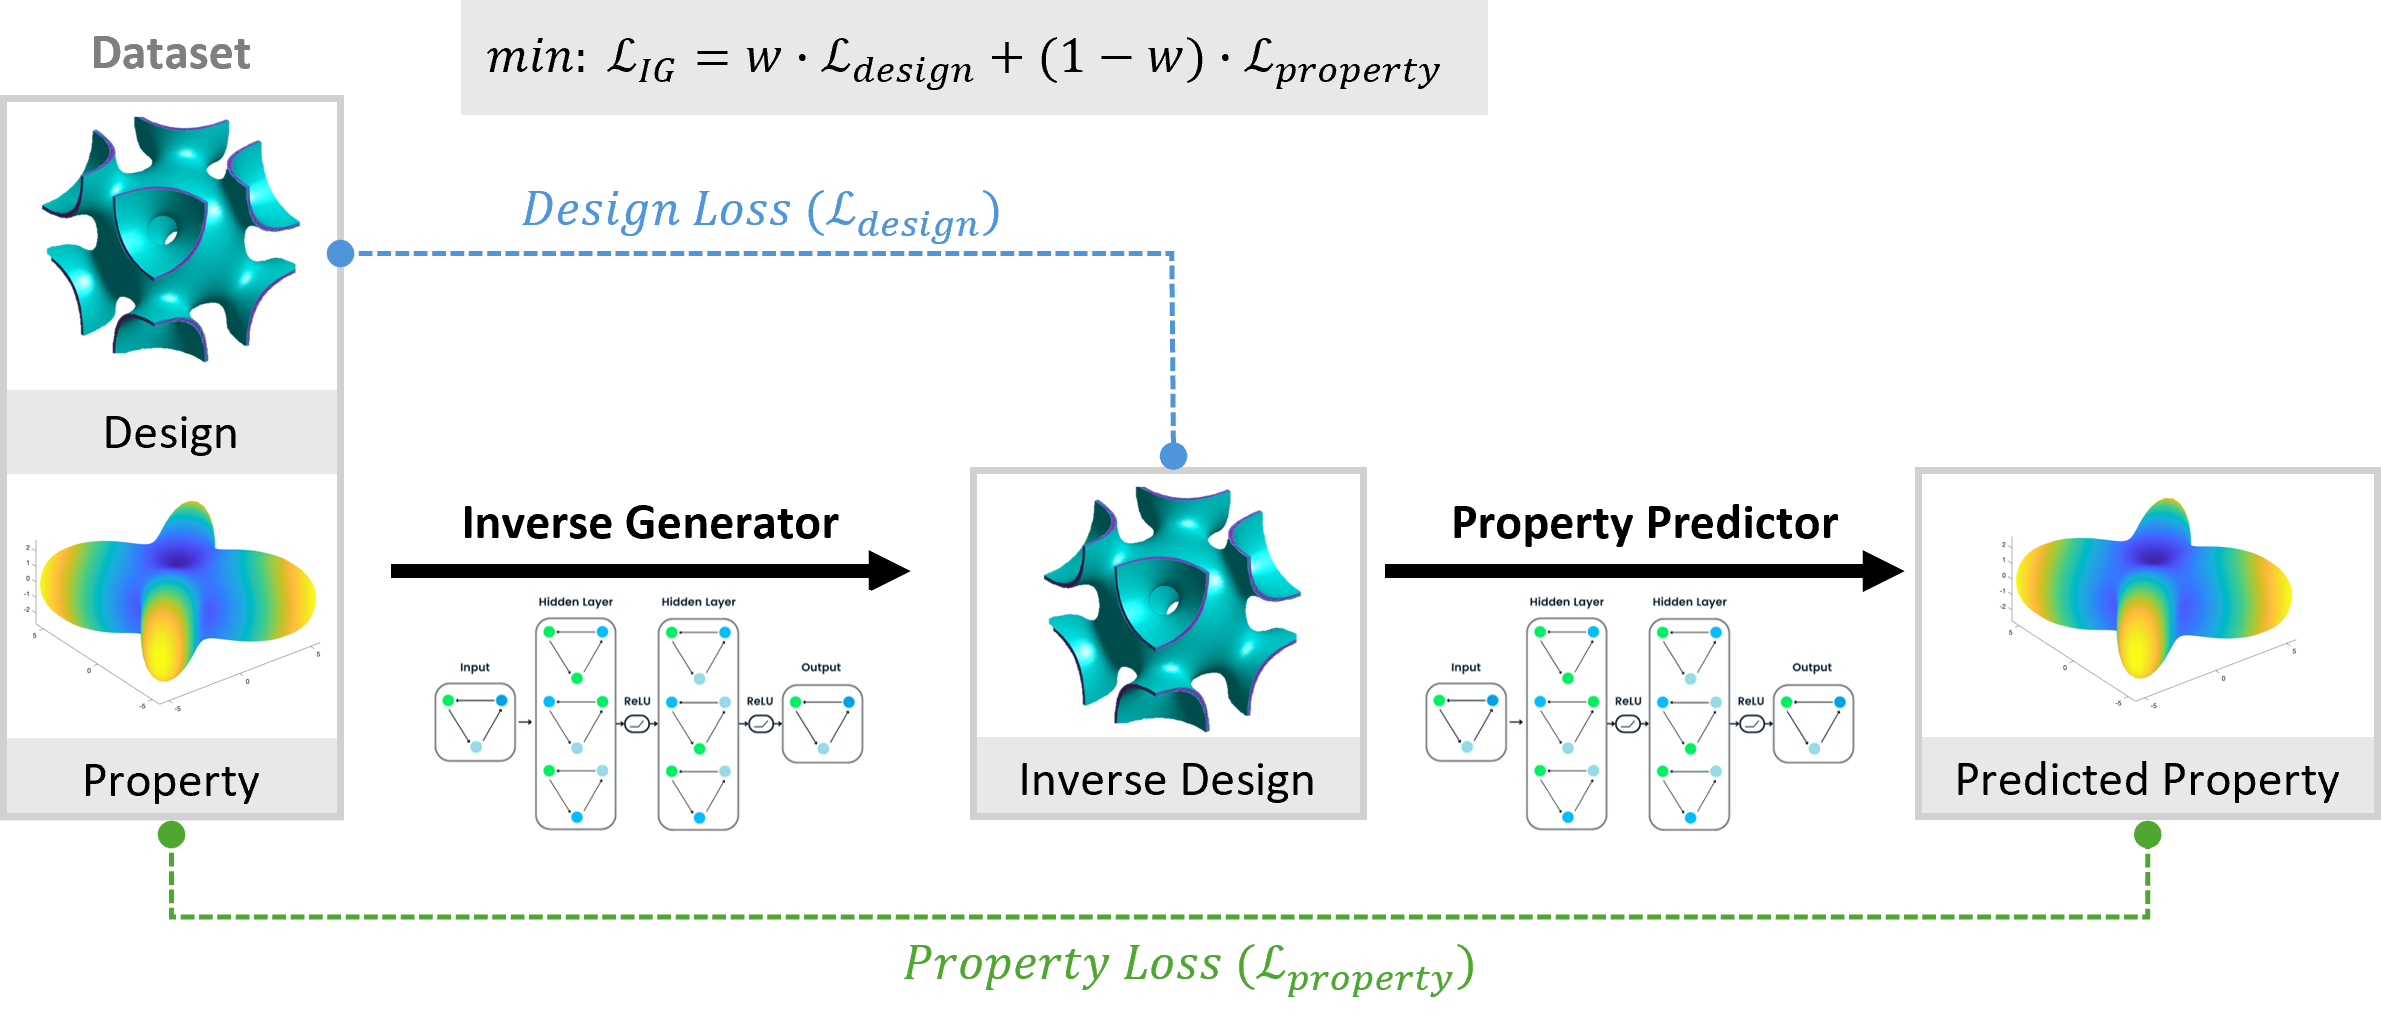

### Import library

Run the cell below to import necessarry python libraries for this tutorial.

In [ ]:
# --- Clone repository from Git
!git clone https://github.com/IDEA-lab-IC/Tutorials.git
%cd Tutorials

# --- Standard library
import time
import math
import random

# --- Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PyTorch
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load predefined functions
from MLPpackage import *
from MLPextention import *

Cloning into 'MLLab'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 17 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 1.07 MiB | 3.63 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/MLLab


-----------

# **1) Create the Property Predictor**

<h4><font color="lightblue">Load dataset and prepare dataset</font></h3>

In [ ]:
# --- Load the dataset as numpy array
data  = np.load("dataset_2D_BCC_1000.npz")
prop  = data["prop"]    # input features
param = data["param"]   # target outputs

# --- Determine dimensions
N, prop_dim  = prop.shape
_, param_dim = param.shape

# --- Split dataset
param_train, param_val, param_test, prop_train, prop_val, prop_test = split_prop_param(
    param, prop, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, print_summary=False)

# --- Scale dataset
param_train, param_val, param_test, prop_train, prop_val, prop_test, param_scaler, prop_scaler = scale_datasets(
    param_train, param_val, param_test, prop_train, prop_val, prop_test,
    scale_inputs=True, scale_outputs=True, feature_range=(-1, 1), print_summary=False)

# --- Convert to Torch tensors
Param_train, Prop_train, Param_val, Prop_val, Param_test, Prop_test = map(
    lambda a: torch.from_numpy(a).float(),
    (param_train, prop_train, param_val, prop_val, param_test, prop_test))

<h4><font color="lightblue">Create DataLoaders</font></h3>

In [ ]:
BATCH_SIZE = 256 # number of samples per mini-batch

train_loader = DataLoader(TensorDataset(Param_train, Prop_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(Param_val,   Prop_val),   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(Param_test,  Prop_test),  batch_size=BATCH_SIZE, shuffle=False)

#### Define a Property Predictor model and train the model

In this section, an MLP-based property predictor is defined and trained to learn the forward mapping from metamaterial unit cell parameters to their corresponding effective properties. The trained model takes cell parameters as input and outputs the predicted material properties, serving as a forward physical surrogate for subsequent inverse design.

In [ ]:
HIDDEN  = (8,)    # change as needed
DROPOUT = 0.0

# Create the model
Proppred = MLP(in_dim=param_dim, hidden=HIDDEN, out_dim=prop_dim, dropout=DROPOUT)

# Parameter counter
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

# Print model summary
print(Proppred)
print(f"Trainable parameters: {count_params(Proppred):,}")

MLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=7, bias=True)
  )
)
Trainable parameters: 103


In [ ]:
Proppred, train_losses, val_losses = train_model(
    Proppred,
    train_loader,
    val_loader,
    epochs=300, # training epoch
    patience=20, # early stopping if no validation improvement
    criterion=nn.MSELoss(), # Mean Squared Error (MSE) loss for regression
    optimizer=torch.optim.AdamW(Proppred.parameters(), lr=1e-3, weight_decay=1e-4), # Adam optimizer – efficient and commonly used
)

=== Training started ===
Epoch   1/300 | Train: 0.317079 | Val: 0.325082
Epoch  20/300 | Train: 0.138851 | Val: 0.137440
Epoch  40/300 | Train: 0.039063 | Val: 0.035724
Epoch  60/300 | Train: 0.011280 | Val: 0.010214
Epoch  80/300 | Train: 0.005290 | Val: 0.004914
Epoch 100/300 | Train: 0.003381 | Val: 0.003172
Epoch 120/300 | Train: 0.002502 | Val: 0.002361
Epoch 140/300 | Train: 0.002011 | Val: 0.001891
Epoch 160/300 | Train: 0.001715 | Val: 0.001598
Epoch 180/300 | Train: 0.001524 | Val: 0.001412
Epoch 200/300 | Train: 0.001385 | Val: 0.001265
Epoch 220/300 | Train: 0.001278 | Val: 0.001153
Epoch 240/300 | Train: 0.001185 | Val: 0.001064
Epoch 260/300 | Train: 0.001105 | Val: 0.000979
Epoch 280/300 | Train: 0.001038 | Val: 0.000908
Epoch 300/300 | Train: 0.000984 | Val: 0.000848
=== Training complete ===


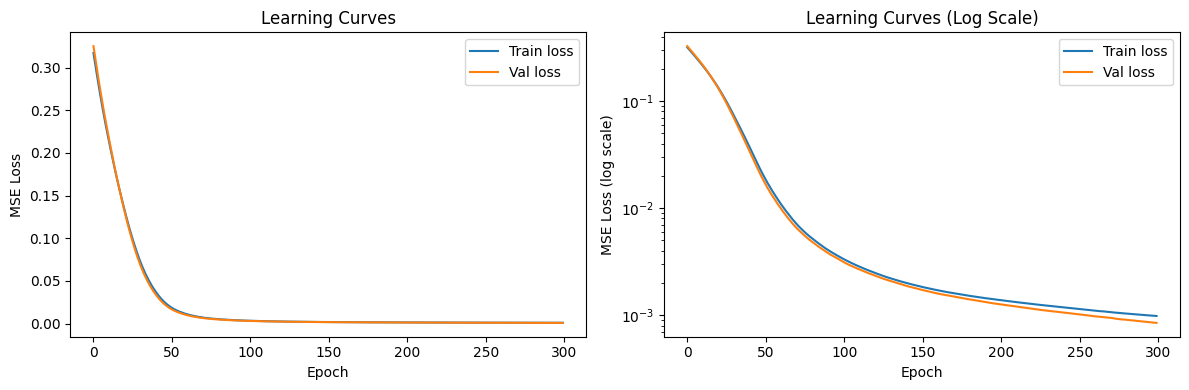

In [ ]:
plot_learning_curves(train_losses, val_losses, metric_name="MSE Loss")

#### Test Property Predictor

Test the tained Property Predictor by comparing the predicted properties with the ground truth property values.

In [ ]:
prop_true_plot, prop_pred_plot, mae, rmse, r2 = evaluate_model(
    Proppred,
    test_loader,
    out_dim=prop_dim,
    out_scaler=prop_scaler,
    scale_outputs=True, # if output is scaled in preprocessing, 'True' is to inverst scale, and compute y in original scale.
    print_summary=True,
)

=== Test Metrics per Output ===
Output 0: MAE=0.003852, RMSE=0.005218, R^2=0.9945
Output 1: MAE=0.003133, RMSE=0.003946, R^2=0.9948
Output 2: MAE=0.002721, RMSE=0.003573, R^2=0.9879
Output 3: MAE=0.003979, RMSE=0.005291, R^2=0.9944
Output 4: MAE=0.002259, RMSE=0.002824, R^2=0.9924
Output 5: MAE=0.002102, RMSE=0.002691, R^2=0.9960
Output 6: MAE=0.007455, RMSE=0.009429, R^2=0.9956

Overall MAE:  0.003643
Overall RMSE: 0.004710
Mean R^2:     0.9937


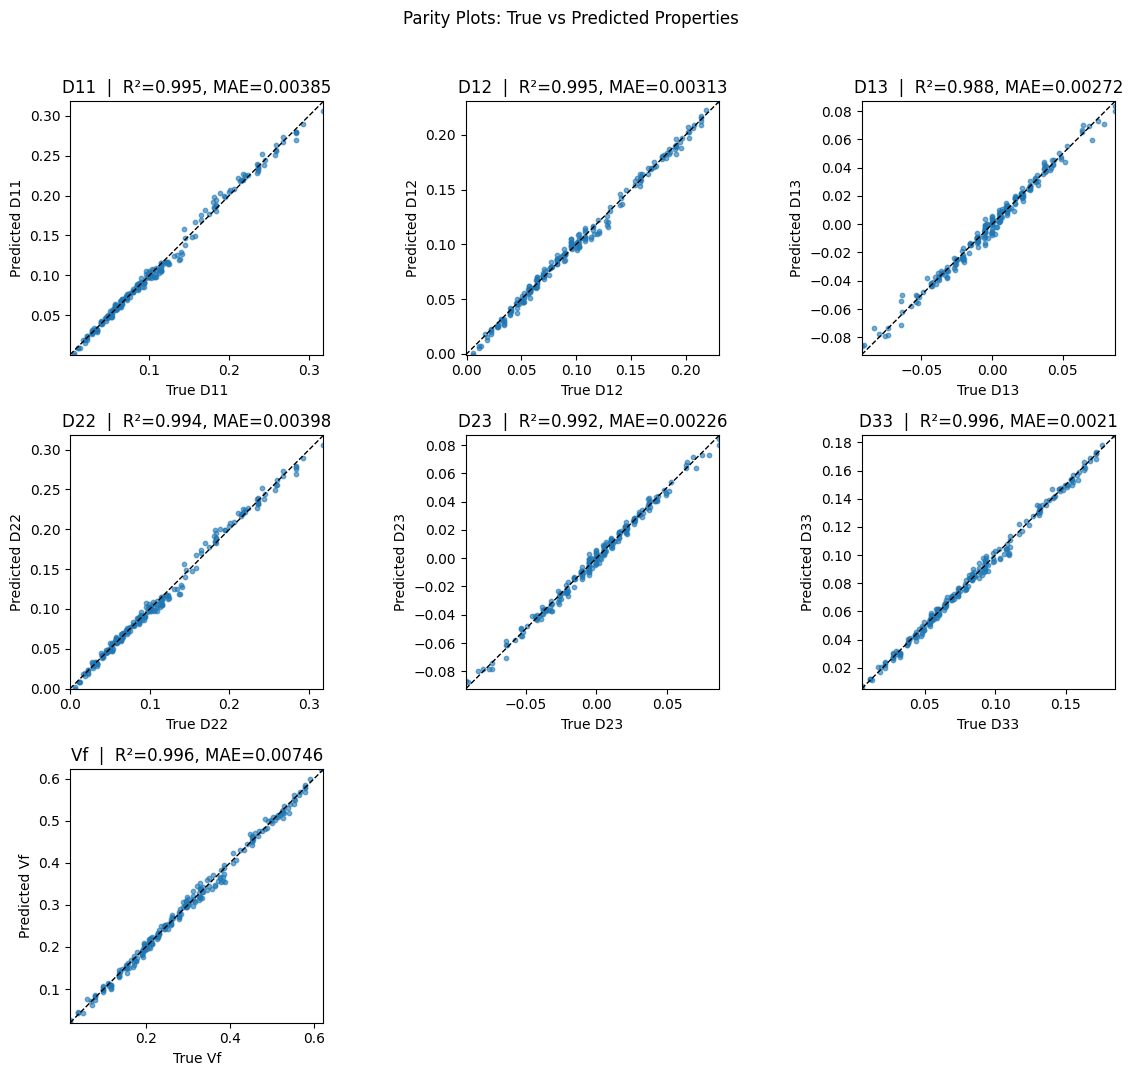

In [ ]:
prop_names = ["D11","D12","D13","D22","D23","D33","Vf"]
plot_property_parity_plots(
    prop_true=prop_true_plot,
    prop_pred=prop_pred_plot,
    mae=mae,
    r2=r2,
    out_dim=prop_dim,
    prop_names=prop_names
)

You should achieve a high accuracy with the trained Property Predictor.

# **2) Build and train the inverse generator considering property consistency**

#### Define a Inverse Generator model

Similar as previous tutorials, we initialise a MLP model as Inverse Generator.

In [ ]:
INV_HIDDEN  = (16, 8)   # change as needed
INV_DROPOUT = 0.0

# Inverse model: input = 7D property → output = 4D param
Inversegen = MLP(
    in_dim=prop_dim,     # 7
    hidden=INV_HIDDEN,
    out_dim=param_dim,   # 4
    dropout=INV_DROPOUT
)

# Freeze Proppred (pretrained already, not to be trained here)
Proppred.eval()
for p in Proppred.parameters():
    p.requires_grad = False

# Count parameters
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print(Inversegen)
print(f"Trainable parameters (Inversegen): {count_params(Inversegen):,}")

MLP(
  (net): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)
Trainable parameters (Inversegen): 300


#### <span style="color:lightblue;">Create DataLoaders</span>

In [ ]:
BATCH_SIZE_INV = 256

# We only need prop as the supervised target for the consistency loss
inv_train_loader = DataLoader(TensorDataset(Prop_train), batch_size=BATCH_SIZE_INV, shuffle=True)
inv_val_loader   = DataLoader(TensorDataset(Prop_val),   batch_size=BATCH_SIZE_INV, shuffle=False)
inv_test_loader  = DataLoader(TensorDataset(Prop_test),  batch_size=BATCH_SIZE_INV, shuffle=False)

#### New Loss Function

Different from the previous tutorials, the loss function here is defined based on the discrepancy between the property predicted from the parameters generated by the inverse generator and the target property.

In [ ]:
criterion_prop = nn.MSELoss()
optimizer_inv  = torch.optim.Adam(Inversegen.parameters(), lr=1e-3, weight_decay=1e-5)

EPOCHS_INV, PATIENCE_INV = 150, 20
train_losses_inv, val_losses_inv = [], []
best_val_inv, best_state_inv, wait = float("inf"), None, 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("=== Training Inversegen with property-consistency loss ===")
for ep in range(1, EPOCHS_INV + 1):
    # ----- Train -----
    Inversegen.train()
    total = 0.0
    for (prop_batch,) in inv_train_loader:
        prop_batch = prop_batch.to(device)

        # Predict parameters from properties
        param_hat = Inversegen(prop_batch)                     # shape (B,4)

        # Predict properties from predicted parameters using frozen Proppred
        prop_hat  = Proppred(param_hat)                             # shape (B,7)

        # Consistency loss: predicted props vs input target props
        loss = criterion_prop(prop_hat, prop_batch)

        optimizer_inv.zero_grad()
        loss.backward()
        optimizer_inv.step()

        total += loss.item() * prop_batch.size(0)
    tr_loss = total / len(inv_train_loader.dataset)

    # ----- Validate -----
    Inversegen.eval()
    total = 0.0
    with torch.no_grad():  # no grad for evaluation
        for (prop_batch,) in inv_val_loader:
            prop_batch = prop_batch.to(device)
            param_hat  = Inversegen(prop_batch)
            prop_hat   = Proppred(param_hat)
            loss       = criterion_prop(prop_hat, prop_batch)
            total += loss.item() * prop_batch.size(0)
    va_loss = total / len(inv_val_loader.dataset)

    train_losses_inv.append(tr_loss)
    val_losses_inv.append(va_loss)
    if ep % max(1, EPOCHS_INV // 10) == 0 or ep == 1:
        print(f"Epoch {ep:3d}/{EPOCHS_INV} | Train {tr_loss:.6f} | Val {va_loss:.6f}")

    # Early stopping on validation loss
    if va_loss < best_val_inv - 1e-9:
        best_val_inv, best_state_inv, wait = va_loss, {k: v.detach().cpu().clone() for k, v in Inversegen.state_dict().items()}, 0
    else:
        wait += 1
        if wait >= PATIENCE_INV:
            print(f"Early stopping at epoch {ep} (best val={best_val_inv:.6f})")
            break

# Restore best weights
if best_state_inv is not None:
    Inversegen.load_state_dict(best_state_inv)
print("=== Inversegen training complete ===")


=== Training Inversegen with property-consistency loss ===
Epoch   1/150 | Train 0.185134 | Val 0.195623
Epoch  15/150 | Train 0.112061 | Val 0.117911
Epoch  30/150 | Train 0.068594 | Val 0.075184
Epoch  45/150 | Train 0.041373 | Val 0.045931
Epoch  60/150 | Train 0.022672 | Val 0.028006
Epoch  75/150 | Train 0.013399 | Val 0.018149
Epoch  90/150 | Train 0.002904 | Val 0.003605
Epoch 105/150 | Train 0.000907 | Val 0.000891
Epoch 120/150 | Train 0.000649 | Val 0.000605
Epoch 135/150 | Train 0.000541 | Val 0.000492
Epoch 150/150 | Train 0.000468 | Val 0.000419
=== Inversegen training complete ===


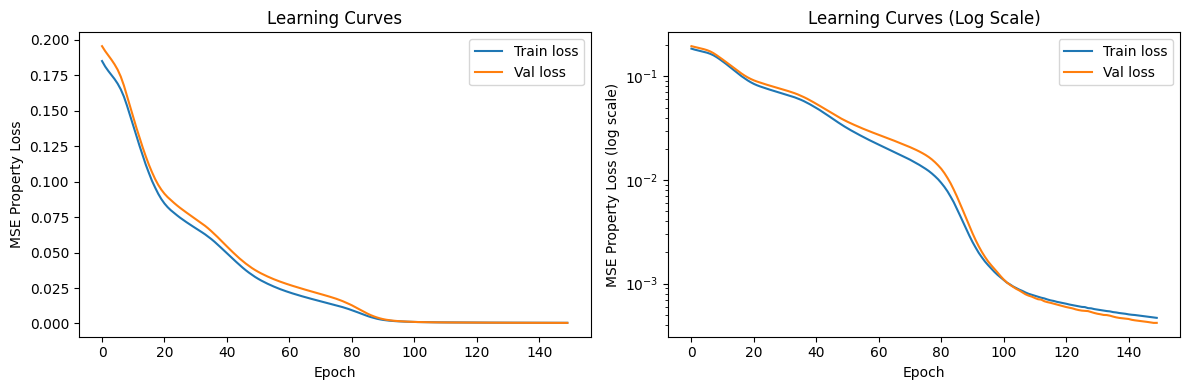

In [ ]:
plot_learning_curves(train_losses_inv, val_losses_inv, metric_name="MSE Property Loss")

#### Test Trained Inverse Generator

Predicted property:

$$
\hat{p} = \mathrm{Proppred}(\mathrm{Inversegen}(\mathrm{prop}))
$$

Ground-truth property:

$$
p = \mathrm{prop}
$$


The accuracy of the inverse generator is evaluated by comparing the predicted cell properties with the target properties.

To illustrate that the generated cell is not necessarily identical to the dataset cell associated with the input target properties, the error in the generated cell parameters is also reported. Despite the low parameter reconstruction similarity, high accuracy in the obtained properties can still be achieved.

In [ ]:
metrics = evaluate_inverse_mapping(
    Inversegen=Inversegen,
    Proppred=Proppred,
    inv_test_loader=inv_test_loader,
    device=device,
    Param_test=Param_test,
    print_report=True
)

=== Test property consistency (per output) ===
d1: MAE=0.016878  RMSE=0.024121  R^2=0.9968
d2: MAE=0.015696  RMSE=0.020767  R^2=0.9981
d3: MAE=0.018021  RMSE=0.025896  R^2=0.9936
d4: MAE=0.016608  RMSE=0.022358  R^2=0.9973
d5: MAE=0.014092  RMSE=0.019364  R^2=0.9964
d6: MAE=0.013272  RMSE=0.020713  R^2=0.9980
d7: MAE=0.017101  RMSE=0.023344  R^2=0.9975
Overall  MAE=0.015953  RMSE=0.022366  Mean R^2=0.9968

=== Test parameter error (per output, sanity check) ===
r1: MAE=0.306652  RMSE=0.320576  R^2=0.6295
r2: MAE=0.042040  RMSE=0.052500  R^2=0.9908
r3: MAE=0.267317  RMSE=0.286507  R^2=0.7038
r4: MAE=0.128134  RMSE=0.152008  R^2=0.9226
Overall  MAE=0.186036  RMSE=0.202898  Mean R^2=0.8117


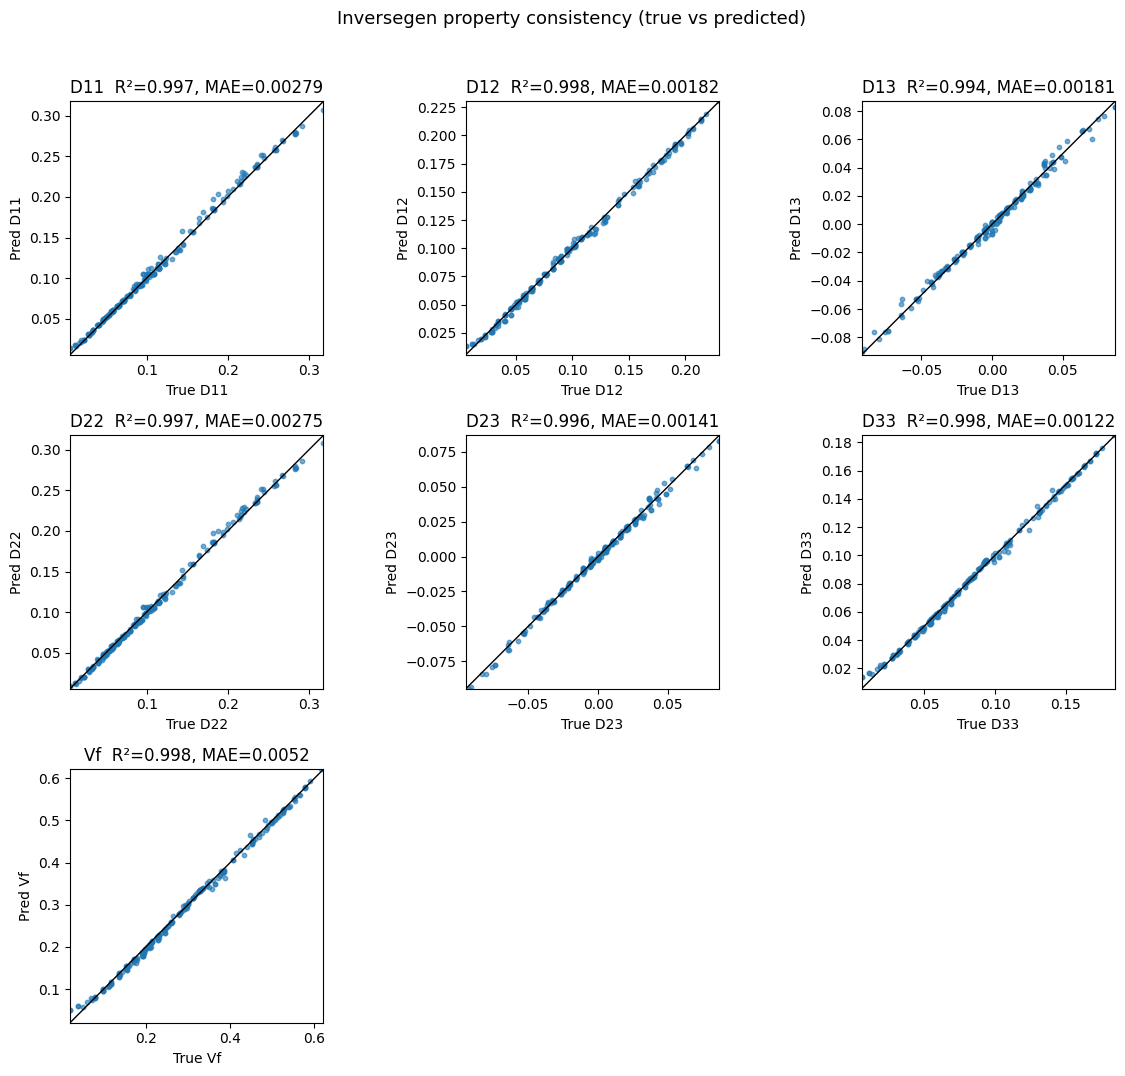

In [ ]:
results = plot_inverse_property_consistency(
    Inversegen=Inversegen,
    Proppred=Proppred,
    inv_test_loader=inv_test_loader,
    device=device,
    scaler_out=prop_scaler,
    scale_outputs=True,
    prop_names=["D11","D12","D13","D22","D23","D33","Vf"]
)

It can be observed that the predicted properties of the obtained cells show high agreement with the target properties.